## Example for computing parallel imaging g-factor using BART Python interface

Author: Jon Tamir <jtamir@eecs.berkeley.edu>

In [1]:
import numpy as np

import time

import cfl
from bart import bart

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

## Create multi-channel phantom in k-space

In [2]:
nx = 128
ny = 128
nc = 8

rx = 1
ry = 4

n_mc = 30


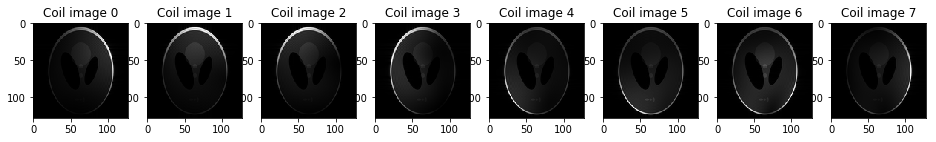

In [3]:
ksp = bart(1, 'phantom -x {} -s {} -k'.format(nx, nc)).squeeze()
cimg = bart(1, 'fft -iu 3', ksp)

plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(cimg[:,:,i]).squeeze(), cmap='gray')
    plt.title('Coil image {}'.format(i))

## Estimate coil sensitivities

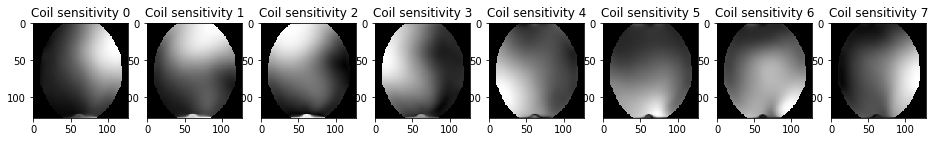

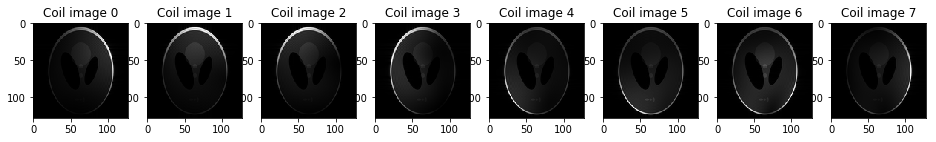

In [4]:
sens = bart(1, 'ecalib -m1', ksp[:,:,None,:]).squeeze()

plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(sens[:,:,i]).squeeze(), cmap='gray')
    plt.title('Coil sensitivity {}'.format(i))
    
plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(cimg[:,:,i]).squeeze(), cmap='gray')
    plt.title('Coil image {}'.format(i))

## Create sampling patterns

Text(0.5,1,'Cartesian grid sampling pattern (N=4096.0)')

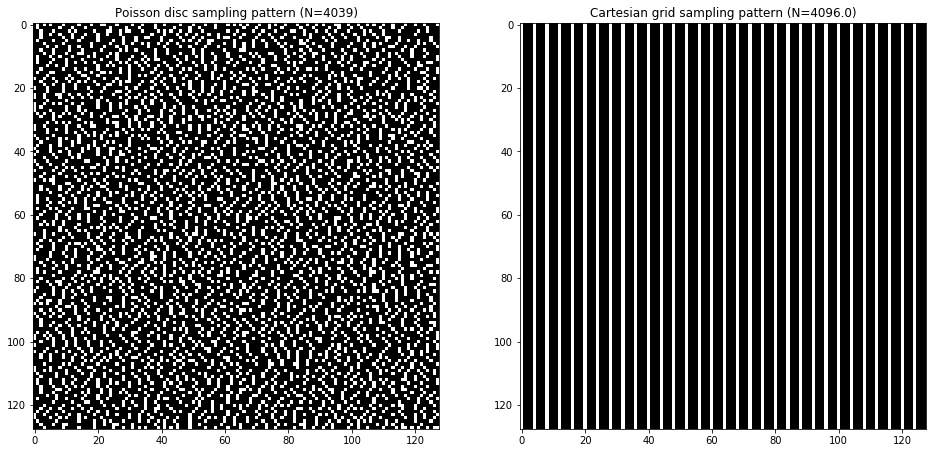

In [5]:
mask_pd = bart(1, 'poisson -Y {} -Z {} -y {} -z {}'.format(nx, ny, rx, ry)).squeeze() != 0
mask_cg = np.zeros((nx, ny))
mask_cg[::rx,::ry] = 1


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(mask_pd, cmap='gray')
plt.title('Poisson disc sampling pattern (N={})'.format(np.sum(mask_pd)))
plt.subplot(1, 2, 2)
plt.imshow(mask_cg, cmap='gray')
plt.title('Cartesian grid sampling pattern (N={})'.format(np.sum(mask_cg)))

## apply masks and reconstruct

Text(0.5,1,'Cartesian grid zero-filled ')

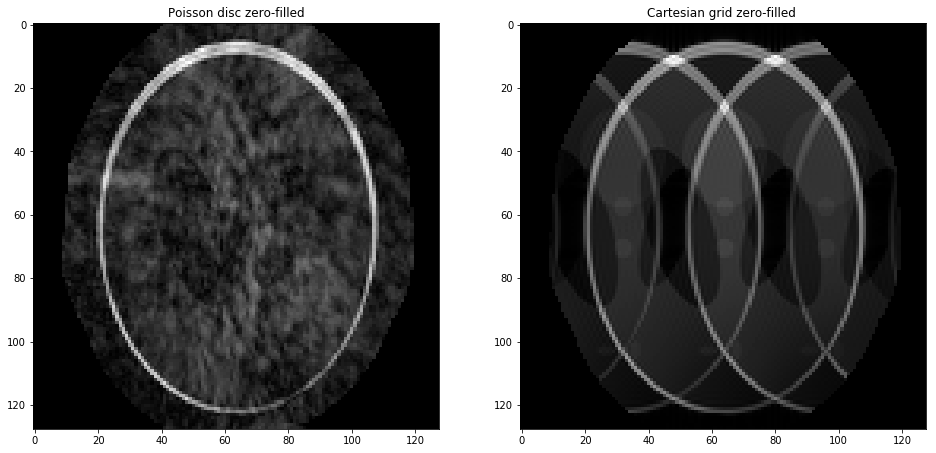

In [6]:
ksp_cg = ksp.copy() * mask_cg[:,:,None]
ksp_pd = ksp.copy() * mask_pd[:,:,None]

reco_pd_zfill = np.sum(bart(1, 'fft -iu 3', ksp_pd) * np.conj(sens), axis=2)
reco_cg_zfill = np.sum(bart(1, 'fft -iu 3', ksp_cg) * np.conj(sens), axis=2)


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(abs(reco_pd_zfill).squeeze(), cmap='gray')
plt.title('Poisson disc zero-filled')

plt.subplot(1, 2, 2)
plt.imshow(abs(reco_cg_zfill).squeeze(), cmap='gray')
plt.title('Cartesian grid zero-filled ')


(128, 128)


Text(0.5,1,'Cartesian grid noiseless reconstruction')

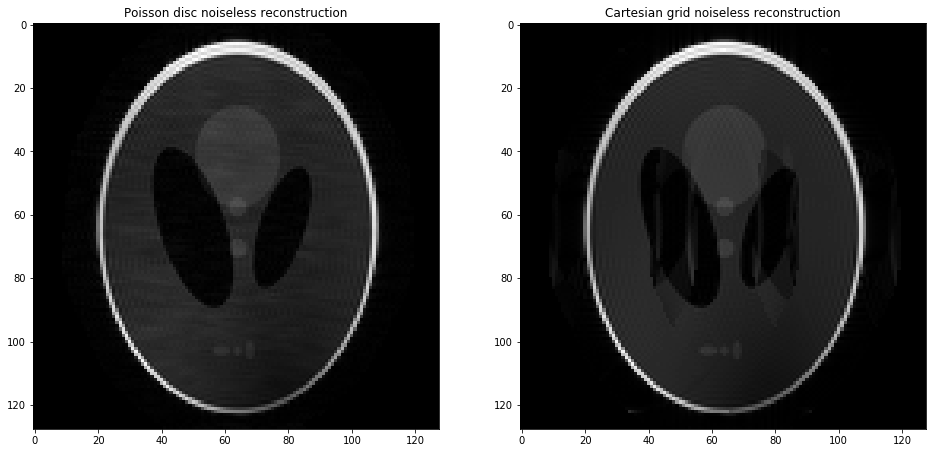

In [7]:
reco_cg_clean = bart(1, 'pics -S -i50', ksp_cg[:,:,None,:], sens[:,:,None,:])
reco_pd_clean = bart(1, 'pics -S -i50', ksp_pd[:,:,None,:], sens[:,:,None,:])
print(reco_cg_clean.shape)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(abs(reco_pd_clean).squeeze(), cmap='gray')
plt.title('Poisson disc noiseless reconstruction')

plt.subplot(1, 2, 2)
plt.imshow(abs(reco_cg_clean).squeeze(), cmap='gray')
plt.title('Cartesian grid noiseless reconstruction')

## repeat reconstruction with N_MC noise instances

In [8]:
recons_cg = np.zeros((nx, ny, n_mc), dtype=np.complex)
recons_pd = np.zeros((nx, ny, n_mc), dtype=np.complex)

tic = time.time()
for i in range(n_mc):

    ksp_noise = np.random.randn(*ksp.shape) + 1j*np.random.randn(*ksp.shape)
    ksp_noise_cg = mask_cg[:,:,None] * (ksp + ksp_noise)
    ksp_noise_pd = mask_pd[:,:,None] * (ksp + ksp_noise)
        
    recons_cg[:,:,i] = bart(1, 'pics -S -i 50', ksp_noise_cg[:,:,None,:], sens[:,:,None,:])
    recons_pd[:,:,i] = bart(1, 'pics -S -i 50', ksp_noise_pd[:,:,None,:], sens[:,:,None,:])
    
toc = time.time()

print('Done ({} s)'.format(toc - tic))

Done (20.652801036834717 s)


## repeat reconstruction with N_MC noise-only instances

In [9]:
recons_noise = np.zeros((nx, ny, n_mc), dtype=np.complex)

tic = time.time()
for i in range(n_mc):
    
    ksp_noise = np.random.randn(*ksp.shape) + 1j*np.random.randn(*ksp.shape)
    recons_noise[:,:,i] = bart(1, 'pics -S -i 50', ksp_noise[:,:,None,:], sens[:,:,None,:])
    
toc = time.time()

print('Done ({} s)'.format(toc - tic))

Done (8.522355079650879 s)


## compute g-factor

Max PD g-factor value: 3.9294463830302027
Max CG g-factor value: 10.958389042524324


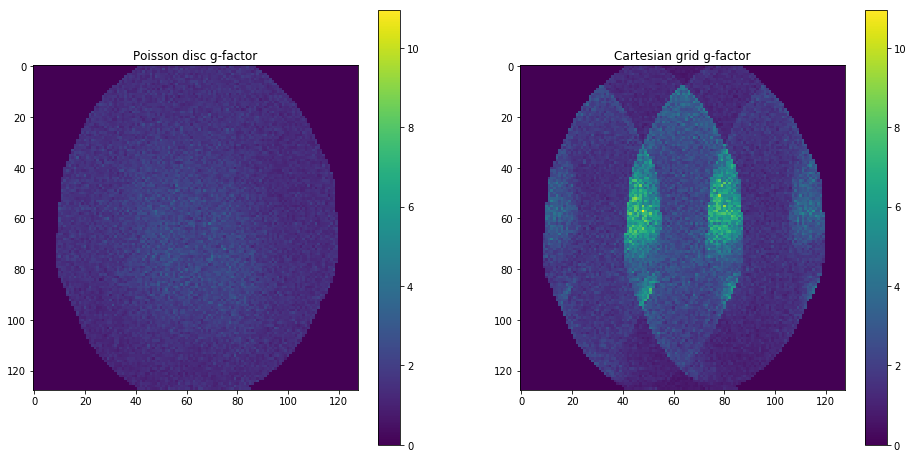

In [12]:
recon_noise_std = np.std(recons_noise, axis=2)
gfactor_cg = np.divide(np.std(recons_cg.real, axis=2), recon_noise_std, where=abs(recons_cg[:,:,0].squeeze()) != 0)
gfactor_pd = np.divide(np.std(recons_pd.real, axis=2), recon_noise_std, where=abs(recons_pd[:,:,0].squeeze()) != 0)

gfactor_cg /= np.sqrt(rx * ry)
gfactor_pd /= np.sqrt(rx * ry)

max_gf_pd = np.max(gfactor_pd)
max_gf_cg = np.max(gfactor_cg)

print('Max PD g-factor value: {}'.format(max_gf_pd))
print('Max CG g-factor value: {}'.format(max_gf_cg))


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(gfactor_pd, vmax=np.max((max_gf_pd, max_gf_cg)))
plt.title('Poisson disc g-factor')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(gfactor_cg, vmax=np.max((max_gf_pd, max_gf_cg)))
plt.title('Cartesian grid g-factor')
plt.colorbar()